# Mount to Drive
(This is in case you are working on google drive)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set directory to the folder here
%cd

# Import Libraries


In [3]:
import os
import cv2
import shutil
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC, F1Score, Metric
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Binarizer

random.seed(42)

# Prepare the data

In [7]:
training_path = os.getcwd() + '/Data/train'
validation_path = os.getcwd() + '/Data/validation'
testing_other_path = os.getcwd() + '/Data/test_other'
testing_same_path = os.getcwd() + '/Data/test_same'

In [9]:
data_generator = ImageDataGenerator()

train_it = data_generator.flow_from_directory(training_path,
                                              class_mode="binary",
                                              batch_size=32,
                                              target_size = (224, 224))

validation_it = data_generator.flow_from_directory(validation_path,
                                                   class_mode="binary",
                                                   batch_size=16,
                                                   target_size = (224, 224))

test_it = data_generator.flow_from_directory(testing_other_path,
                                             class_mode="binary",
                                             batch_size=16,
                                             target_size = (224, 224),)

test_primary_it = data_generator.flow_from_directory(testing_same_path,
                                             class_mode="binary",
                                             batch_size=16,
                                             target_size = (224, 224),)

batchX, batchY = train_it.next()
print("BatchX shape: {}, min: {}, max: {}".format(batchX.shape, batchX.min(), batchX.max()))
print("BatchY shape: {}".format(batchY.shape))

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
BatchX shape: (32, 224, 224, 3), min: 0.0, max: 255.0
BatchY shape: (32,)


# ResNet101 Model Training

###### SET UP

In [ ]:
# Load pre-trained ResNet101 model without including top layers
resnet_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the ResNet101 model
for layer in resnet_model.layers:
    layer.trainable = False

# Setup classification metrics
precision_metric = Precision()
recall_metric = Recall()
f1 = F1Score()
auc_metric = AUC()

# Add custom layers
x = resnet_model.output
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Add final dense layer with 1 output neuron for binary classification
predictions = Dense(1, activation='sigmoid', name='predictions')(x)

# Define the model
model = Model(inputs=resnet_model.input, outputs=predictions)

# Define the optimizer with an initial learning rate
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', precision_metric, recall_metric, f1, auc_metric])

171446536/171446536 [==============================] - 1s 0us/step


###### TRAINING

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint("Models/ResNet101.h5", save_best_only=True, save_weights_only=True, save_freq=5)
]
# /PromisingModels

# Fit the model with early stopping callback
history = model.fit_generator(
  train_it,
  validation_data=validation_it,
  epochs=40,
  steps_per_epoch=10,
  validation_steps=5,
  verbose=1,
  callbacks=callbacks
)

<ipython-input-10-65ce6587c81a>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
 4/10 [===========>..................] - ETA: 1:19 - loss: 0.9679 - accuracy: 0.4688 - precision: 0.4783 - recall: 0.3333 - f1_score: 0.6804 - auc: 0.4589

 9/10 [==========================>...] - ETA: 12s - loss: 0.9263 - accuracy: 0.5069 - precision: 0.5583 - recall: 0.5652 - f1_score: 0.7171 - auc: 0.4854

10/10 [==============================] - 258s 18s/step - loss: 0.9409 - accuracy: 0.5031 - precision: 0.5430 - recall: 0.5771 - f1_score: 0.7071 - auc: 0.4785 - val_loss: 1.4419 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 1.0000 - val_f1_score: 0.5714 - val_auc: 0.7389 - lr: 0.0010
Epoch 2/40
 4/10 [===========>..................] - ETA: 1:18 - loss: 0.8413 - accuracy: 0.5625 - precision: 0.5618 - recall: 0.7463 - f1_score: 0.6872 - auc: 0.5269

 9/10 [==========================>...] - ETA: 12s - loss: 0.7448 - accuracy: 0.5833 - precision: 0.5714 - recall: 0.6667 - f1_score: 0.6667 - auc: 0.6102

10/10 [==============================] - 166s 16s/step - loss: 0.7417 - accuracy: 0.5844 - precision: 0.5747 - recall: 0.6289 - f1_score: 0.6639 - auc: 0.6143 - val_loss: 1.1182 - val_accuracy: 0.5750 - val_precision: 0.5750 - val_recall: 1.0000 - val_f1_score: 0.7302 - val_auc: 0.7132 - lr: 0.0010
Epoch 3/40
 4/10 [===========>..................] - ETA: 1:15 - loss: 0.8147 - accuracy: 0.4922 - precision: 0.3824 - recall: 0.2281 - f1_score: 0.6162 - auc: 0.4970

 9/10 [==========================>...] - ETA: 12s - loss: 0.7939 - accuracy: 0.5590 - precision: 0.4943 - recall: 0.3413 - f1_score: 0.6087 - auc: 0.5354

10/10 [==============================] - 161s 16s/step - loss: 0.7871 - accuracy: 0.5562 - precision: 0.5000 - recall: 0.3592 - f1_score: 0.6147 - auc: 0.5452 - val_loss: 3.2145 - val_accuracy: 0.5375 - val_precision: 0.5375 - val_recall: 1.0000 - val_f1_score: 0.6992 - val_auc: 0.5798 - lr: 0.0010
Epoch 4/40
 4/10 [===========>..................] - ETA: 1:25 - loss: 0.6787 - accuracy: 0.6406 - precision: 0.6452 - recall: 0.6250 - f1_score: 0.6667 - auc: 0.6962

 9/10 [==========================>...] - ETA: 13s - loss: 0.6738 - accuracy: 0.6528 - precision: 0.6333 - recall: 0.6786 - f1_score: 0.6542 - auc: 0.7029

10/10 [==============================] - 167s 17s/step - loss: 0.6757 - accuracy: 0.6531 - precision: 0.6467 - recall: 0.6750 - f1_score: 0.6667 - auc: 0.6987 - val_loss: 2.7507 - val_accuracy: 0.5750 - val_precision: 0.5750 - val_recall: 1.0000 - val_f1_score: 0.7302 - val_auc: 0.6033 - lr: 0.0010
Epoch 5/40
 4/10 [===========>..................] - ETA: 1:12 - loss: 0.6669 - accuracy: 0.6094 - precision: 0.6351 - recall: 0.6714 - f1_score: 0.7071 - auc: 0.6826

 9/10 [==========================>...] - ETA: 12s - loss: 0.6701 - accuracy: 0.6389 - precision: 0.6604 - recall: 0.6774 - f1_score: 0.6998 - auc: 0.6844

10/10 [==============================] - 171s 17s/step - loss: 0.6753 - accuracy: 0.6500 - precision: 0.6705 - recall: 0.6860 - f1_score: 0.6992 - auc: 0.6838 - val_loss: 2.1202 - val_accuracy: 0.4250 - val_precision: 0.4250 - val_recall: 1.0000 - val_f1_score: 0.5965 - val_auc: 0.7299 - lr: 0.0010
Epoch 6/40
 4/10 [===========>..................] - ETA: 1:15 - loss: 0.6921 - accuracy: 0.5781 - precision: 0.5139 - recall: 0.6607 - f1_score: 0.6087 - auc: 0.6693

 9/10 [==========================>...] - ETA: 12s - loss: 0.7101 - accuracy: 0.6076 - precision: 0.5633 - recall: 0.6692 - f1_score: 0.6318 - auc: 0.6685

10/10 [==============================] - 159s 16s/step - loss: 0.6929 - accuracy: 0.6250 - precision: 0.5954 - recall: 0.6732 - f1_score: 0.6469 - auc: 0.6803 - val_loss: 0.8918 - val_accuracy: 0.5250 - val_precision: 0.4714 - val_recall: 0.9706 - val_f1_score: 0.5965 - val_auc: 0.7794 - lr: 0.0010
Epoch 7/40
 4/10 [===========>..................] - ETA: 1:08 - loss: 0.7392 - accuracy: 0.6172 - precision: 0.7167 - recall: 0.5733 - f1_score: 0.7389 - auc: 0.6494

 9/10 [==========================>...] - ETA: 12s - loss: 0.6595 - accuracy: 0.6528 - precision: 0.6786 - recall: 0.6333 - f1_score: 0.6849 - auc: 0.7019

10/10 [==============================] - 171s 17s/step - loss: 0.6616 - accuracy: 0.6438 - precision: 0.6625 - recall: 0.6386 - f1_score: 0.6831 - auc: 0.6950 - val_loss: 0.6947 - val_accuracy: 0.5375 - val_precision: 0.5352 - val_recall: 0.9048 - val_f1_score: 0.6885 - val_auc: 0.7575 - lr: 0.0010
Epoch 8/40
 4/10 [===========>..................] - ETA: 1:22 - loss: 0.6072 - accuracy: 0.6797 - precision: 0.6721 - recall: 0.6613 - f1_score: 0.6526 - auc: 0.7488

 9/10 [==========================>...] - ETA: 12s - loss: 0.5990 - accuracy: 0.6944 - precision: 0.7286 - recall: 0.6711 - f1_score: 0.6909 - auc: 0.7609

10/10 [==============================] - 161s 16s/step - loss: 0.6011 - accuracy: 0.6969 - precision: 0.7261 - recall: 0.6786 - f1_score: 0.6885 - auc: 0.7604 - val_loss: 0.6396 - val_accuracy: 0.7125 - val_precision: 0.6806 - val_recall: 1.0000 - val_f1_score: 0.7597 - val_auc: 0.8453 - lr: 0.0010
Epoch 9/40
 4/10 [===========>..................] - ETA: 1:18 - loss: 0.5340 - accuracy: 0.7422 - precision: 0.7368 - recall: 0.8116 - f1_score: 0.7005 - auc: 0.8204

 9/10 [==========================>...] - ETA: 12s - loss: 0.6462 - accuracy: 0.6910 - precision: 0.6606 - recall: 0.7676 - f1_score: 0.6605 - auc: 0.7368

10/10 [==============================] - 169s 17s/step - loss: 0.6401 - accuracy: 0.7000 - precision: 0.6611 - recall: 0.7727 - f1_score: 0.6498 - auc: 0.7436 - val_loss: 0.9984 - val_accuracy: 0.5875 - val_precision: 0.5733 - val_recall: 0.9773 - val_f1_score: 0.7097 - val_auc: 0.7494 - lr: 0.0010
Epoch 10/40
 4/10 [===========>..................] - ETA: 1:16 - loss: 0.5756 - accuracy: 0.6641 - precision: 0.5846 - recall: 0.7037 - f1_score: 0.5934 - auc: 0.7594

 9/10 [==========================>...] - ETA: 13s - loss: 0.5654 - accuracy: 0.6910 - precision: 0.6797 - recall: 0.6444 - f1_score: 0.6383 - auc: 0.7799

10/10 [==============================] - 164s 17s/step - loss: 0.5462 - accuracy: 0.7000 - precision: 0.6884 - recall: 0.6419 - f1_score: 0.6325 - auc: 0.7958 - val_loss: 0.9848 - val_accuracy: 0.5625 - val_precision: 0.5205 - val_recall: 1.0000 - val_f1_score: 0.6441 - val_auc: 0.8070 - lr: 0.0010
Epoch 11/40
 4/10 [===========>..................] - ETA: 1:20 - loss: 0.6159 - accuracy: 0.6719 - precision: 0.5581 - recall: 0.5106 - f1_score: 0.5371 - auc: 0.7217

 9/10 [==========================>...] - ETA: 13s - loss: 0.5951 - accuracy: 0.6806 - precision: 0.6818 - recall: 0.5682 - f1_score: 0.6286 - auc: 0.7622

10/10 [==============================] - 178s 18s/step - loss: 0.6059 - accuracy: 0.6781 - precision: 0.6911 - recall: 0.5667 - f1_score: 0.6383 - auc: 0.7567 - val_loss: 0.8287 - val_accuracy: 0.5750 - val_precision: 0.5152 - val_recall: 0.9444 - val_f1_score: 0.6207 - val_auc: 0.8087 - lr: 0.0010
Epoch 12/40
 4/10 [===========>..................] - ETA: 1:17 - loss: 0.6128 - accuracy: 0.6875 - precision: 0.6615 - recall: 0.7049 - f1_score: 0.6455 - auc: 0.7609

 9/10 [==========================>...] - ETA: 13s - loss: 0.6273 - accuracy: 0.6840 - precision: 0.6623 - recall: 0.7143 - f1_score: 0.6542 - auc: 0.7466

10/10 [==============================] - 177s 18s/step - loss: 0.6195 - accuracy: 0.6875 - precision: 0.6686 - recall: 0.7197 - f1_score: 0.6583 - auc: 0.7492 - val_loss: 0.6824 - val_accuracy: 0.7000 - val_precision: 0.6140 - val_recall: 0.9459 - val_f1_score: 0.6325 - val_auc: 0.8228 - lr: 0.0010
Epoch 13/40
 4/10 [===========>..................] - ETA: 1:16 - loss: 0.6024 - accuracy: 0.6797 - precision: 0.6667 - recall: 0.7385 - f1_score: 0.6736 - auc: 0.7513

 9/10 [==========================>...] - ETA: 12s - loss: 0.5845 - accuracy: 0.6806 - precision: 0.6364 - recall: 0.7664 - f1_score: 0.6447 - auc: 0.7737

10/10 [==============================] - 171s 17s/step - loss: 0.5778 - accuracy: 0.6875 - precision: 0.6393 - recall: 0.7748 - f1_score: 0.6412 - auc: 0.7785 - val_loss: 0.6008 - val_accuracy: 0.6625 - val_precision: 0.6600 - val_recall: 0.7674 - val_f1_score: 0.6992 - val_auc: 0.7473 - lr: 0.0010
Epoch 14/40
 4/10 [===========>..................] - ETA: 1:18 - loss: 0.5313 - accuracy: 0.7734 - precision: 0.8065 - recall: 0.7463 - f1_score: 0.6872 - auc: 0.8281

 9/10 [==========================>...] - ETA: 13s - loss: 0.5277 - accuracy: 0.7500 - precision: 0.7714 - recall: 0.7297 - f1_score: 0.6789 - auc: 0.8217

10/10 [==============================] - 177s 18s/step - loss: 0.5224 - accuracy: 0.7469 - precision: 0.7532 - recall: 0.7296 - f1_score: 0.6639 - auc: 0.8233 - val_loss: 0.5974 - val_accuracy: 0.6625 - val_precision: 0.6000 - val_recall: 0.8684 - val_f1_score: 0.6441 - val_auc: 0.8123 - lr: 0.0010
Epoch 15/40
 4/10 [===========>..................] - ETA: 1:19 - loss: 0.6116 - accuracy: 0.6719 - precision: 0.6508 - recall: 0.6721 - f1_score: 0.6455 - auc: 0.7579

 9/10 [==========================>...] - ETA: 13s - loss: 0.5609 - accuracy: 0.7153 - precision: 0.7143 - recall: 0.6835 - f1_score: 0.6511 - auc: 0.7952

10/10 [==============================] - 191s 20s/step - loss: 0.5484 - accuracy: 0.7281 - precision: 0.7347 - recall: 0.6923 - f1_score: 0.6555 - auc: 0.8057 - val_loss: 0.5758 - val_accuracy: 0.7375 - val_precision: 0.5957 - val_recall: 0.9333 - val_f1_score: 0.5455 - val_auc: 0.8473 - lr: 0.0010
Epoch 16/40
 4/10 [===========>..................] - ETA: 1:15 - loss: 0.5099 - accuracy: 0.7656 - precision: 0.7742 - recall: 0.7500 - f1_score: 0.6667 - auc: 0.8282

 9/10 [==========================>...] - ETA: 12s - loss: 0.5123 - accuracy: 0.7569 - precision: 0.7448 - recall: 0.7660 - f1_score: 0.6573 - auc: 0.8265

10/10 [==============================] - 155s 16s/step - loss: 0.5028 - accuracy: 0.7656 - precision: 0.7578 - recall: 0.7722 - f1_score: 0.6611 - auc: 0.8344 - val_loss: 0.6196 - val_accuracy: 0.6750 - val_precision: 0.6667 - val_recall: 0.8696 - val_f1_score: 0.7302 - val_auc: 0.7350 - lr: 0.0010
Epoch 17/40
 4/10 [===========>..................] - ETA: 1:16 - loss: 0.5621 - accuracy: 0.7031 - precision: 0.6167 - recall: 0.7115 - f1_score: 0.5778 - auc: 0.8167

 9/10 [==========================>...] - ETA: 13s - loss: 0.6049 - accuracy: 0.7118 - precision: 0.7246 - recall: 0.6897 - f1_score: 0.6697 - auc: 0.7927

10/10 [==============================] - 161s 16s/step - loss: 0.6007 - accuracy: 0.7063 - precision: 0.7261 - recall: 0.6909 - f1_score: 0.6804 - auc: 0.7919 - val_loss: 0.5054 - val_accuracy: 0.7250 - val_precision: 0.6739 - val_recall: 0.8158 - val_f1_score: 0.6441 - val_auc: 0.8421 - lr: 0.0010
Epoch 18/40
 4/10 [===========>..................] - ETA: 1:21 - loss: 0.5643 - accuracy: 0.7344 - precision: 0.6515 - recall: 0.7963 - f1_score: 0.5934 - auc: 0.8022

 9/10 [==========================>...] - ETA: 12s - loss: 0.4943 - accuracy: 0.7639 - precision: 0.6968 - recall: 0.8372 - f1_score: 0.6187 - auc: 0.8489

10/10 [==============================] - 153s 15s/step - loss: 0.5111 - accuracy: 0.7531 - precision: 0.6923 - recall: 0.8125 - f1_score: 0.6207 - auc: 0.8359 - val_loss: 0.4713 - val_accuracy: 0.7625 - val_precision: 0.7568 - val_recall: 0.7368 - val_f1_score: 0.6441 - val_auc: 0.8528 - lr: 0.0010
Epoch 19/40
 4/10 [===========>..................] - ETA: 1:21 - loss: 0.5443 - accuracy: 0.7266 - precision: 0.7193 - recall: 0.6833 - f1_score: 0.6383 - auc: 0.8028

 9/10 [==========================>...] - ETA: 12s - loss: 0.5289 - accuracy: 0.7569 - precision: 0.7752 - recall: 0.7092 - f1_score: 0.6573 - auc: 0.8240

10/10 [==============================] - 171s 18s/step - loss: 0.5334 - accuracy: 0.7406 - precision: 0.7639 - recall: 0.6918 - f1_score: 0.6639 - auc: 0.8209 - val_loss: 0.4625 - val_accuracy: 0.7625 - val_precision: 0.7556 - val_recall: 0.8095 - val_f1_score: 0.6885 - val_auc: 0.8618 - lr: 0.0010
Epoch 20/40
 4/10 [===========>..................] - ETA: 1:22 - loss: 0.4069 - accuracy: 0.8594 - precision: 0.8833 - recall: 0.8281 - f1_score: 0.6667 - auc: 0.9130

 9/10 [==========================>...] - ETA: 13s - loss: 0.4578 - accuracy: 0.7986 - precision: 0.7929 - recall: 0.7929 - f1_score: 0.6542 - auc: 0.8678

10/10 [==============================] - 175s 18s/step - loss: 0.4651 - accuracy: 0.7969 - precision: 0.7975 - recall: 0.7925 - f1_score: 0.6639 - auc: 0.8635 - val_loss: 0.5196 - val_accuracy: 0.7125 - val_precision: 0.6226 - val_recall: 0.9167 - val_f1_score: 0.6207 - val_auc: 0.8772 - lr: 0.0010
Epoch 21/40
 4/10 [===========>..................] - ETA: 1:14 - loss: 0.3814 - accuracy: 0.8516 - precision: 0.8413 - recall: 0.8548 - f1_score: 0.6526 - auc: 0.9109

 9/10 [==========================>...] - ETA: 12s - loss: 0.4041 - accuracy: 0.8160 - precision: 0.8092 - recall: 0.8367 - f1_score: 0.6759 - auc: 0.8967

10/10 [==============================] - 158s 16s/step - loss: 0.4187 - accuracy: 0.8125 - precision: 0.8107 - recall: 0.8303 - f1_score: 0.6804 - auc: 0.8891 - val_loss: 0.5205 - val_accuracy: 0.7625 - val_precision: 0.7451 - val_recall: 0.8636 - val_f1_score: 0.7097 - val_auc: 0.8409 - lr: 0.0010
Epoch 22/40
 4/10 [===========>..................] - ETA: 1:15 - loss: 0.4827 - accuracy: 0.7656 - precision: 0.7286 - recall: 0.8226 - f1_score: 0.6526 - auc: 0.8476

 9/10 [==========================>...] - ETA: 12s - loss: 0.5452 - accuracy: 0.7535 - precision: 0.7230 - recall: 0.7810 - f1_score: 0.6447 - auc: 0.8268

10/10 [==============================] - 166s 17s/step - loss: 0.5321 - accuracy: 0.7594 - precision: 0.7289 - recall: 0.7908 - f1_score: 0.6469 - auc: 0.8329 - val_loss: 0.5626 - val_accuracy: 0.7500 - val_precision: 0.6957 - val_recall: 0.8421 - val_f1_score: 0.6441 - val_auc: 0.8221 - lr: 0.0010
Epoch 23/40
 4/10 [===========>..................] - ETA: 1:14 - loss: 0.5159 - accuracy: 0.7344 - precision: 0.8065 - recall: 0.6944 - f1_score: 0.7200 - auc: 0.8450

 9/10 [==========================>...] - ETA: 12s - loss: 0.4775 - accuracy: 0.7708 - precision: 0.7887 - recall: 0.7568 - f1_score: 0.6789 - auc: 0.8532

10/10 [==============================] - 167s 17s/step - loss: 0.4702 - accuracy: 0.7750 - precision: 0.7962 - recall: 0.7576 - f1_score: 0.6804 - auc: 0.8590 - val_loss: 0.4632 - val_accuracy: 0.7750 - val_precision: 0.6875 - val_recall: 0.9167 - val_f1_score: 0.6207 - val_auc: 0.8826 - lr: 0.0010
Epoch 24/40
 4/10 [===========>..................] - ETA: 1:11 - loss: 0.4650 - accuracy: 0.7969 - precision: 0.8065 - recall: 0.7812 - f1_score: 0.6667 - auc: 0.8730

 9/10 [==========================>...] - ETA: 12s - loss: 0.4175 - accuracy: 0.7951 - precision: 0.7862 - recall: 0.8028 - f1_score: 0.6605 - auc: 0.8929

10/10 [==============================] - 163s 17s/step - loss: 0.4340 - accuracy: 0.7906 - precision: 0.7750 - recall: 0.8000 - f1_score: 0.6526 - auc: 0.8861 - val_loss: 0.5754 - val_accuracy: 0.7375 - val_precision: 0.6667 - val_recall: 0.9231 - val_f1_score: 0.6555 - val_auc: 0.8543 - lr: 0.0010
Epoch 25/40
 4/10 [===========>..................] - ETA: 1:21 - loss: 0.4911 - accuracy: 0.7656 - precision: 0.8209 - recall: 0.7534 - f1_score: 0.7264 - auc: 0.8489

 9/10 [==========================>...] - ETA: 12s - loss: 0.4581 - accuracy: 0.8125 - precision: 0.8481 - recall: 0.8171 - f1_score: 0.7257 - auc: 0.8799

10/10 [==============================] - 155s 16s/step - loss: 0.4464 - accuracy: 0.8125 - precision: 0.8555 - recall: 0.8087 - f1_score: 0.7276 - auc: 0.8856 - val_loss: 0.5043 - val_accuracy: 0.7500 - val_precision: 0.7451 - val_recall: 0.8444 - val_f1_score: 0.7200 - val_auc: 0.8349 - lr: 2.0000e-04
Epoch 26/40
 4/10 [===========>..................] - ETA: 1:26 - loss: 0.3709 - accuracy: 0.8906 - precision: 0.8226 - recall: 0.9444 - f1_score: 0.5934 - auc: 0.9339

 9/10 [==========================>...] - ETA: 13s - loss: 0.4054 - accuracy: 0.8507 - precision: 0.8333 - recall: 0.8633 - f1_score: 0.6511 - auc: 0.9046

10/10 [==============================] - 161s 16s/step - loss: 0.4092 - accuracy: 0.8375 - precision: 0.8239 - recall: 0.8452 - f1_score: 0.6526 - auc: 0.9011 - val_loss: 0.5607 - val_accuracy: 0.7375 - val_precision: 0.6444 - val_recall: 0.8529 - val_f1_score: 0.5965 - val_auc: 0.8408 - lr: 2.0000e-04
Epoch 27/40
 4/10 [===========>..................] - ETA: 1:12 - loss: 0.3713 - accuracy: 0.8359 - precision: 0.7746 - recall: 0.9167 - f1_score: 0.6383 - auc: 0.9172

 9/10 [==========================>...] - ETA: 12s - loss: 0.4024 - accuracy: 0.8403 - precision: 0.8188 - recall: 0.8652 - f1_score: 0.6573 - auc: 0.9084

10/10 [==============================] - 165s 17s/step - loss: 0.4074 - accuracy: 0.8344 - precision: 0.8084 - recall: 0.8654 - f1_score: 0.6555 - auc: 0.9038 - val_loss: 0.4825 - val_accuracy: 0.8000 - val_precision: 0.7381 - val_recall: 0.8611 - val_f1_score: 0.6207 - val_auc: 0.8662 - lr: 2.0000e-04


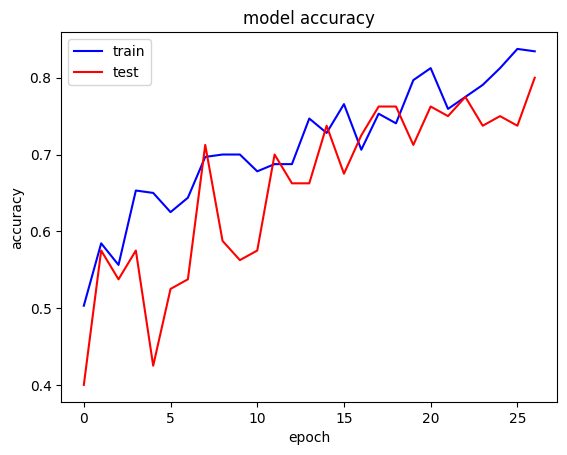

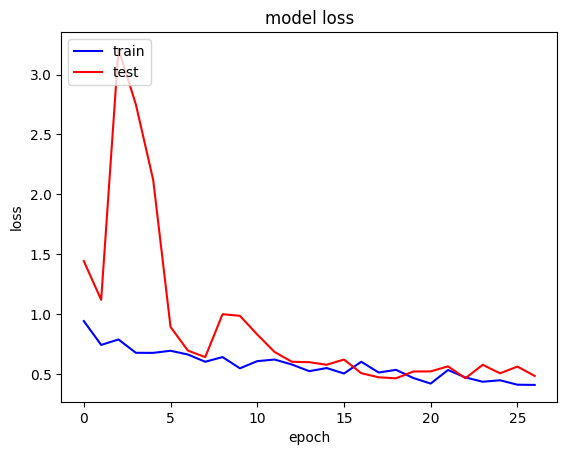

In [ ]:
# Plot the model's training and validation accuracy
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='red')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot the model's training and validation loss
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###### TESTING (Other)

In [ ]:
model.evaluate(test_it, batch_size=5)

25/25 [==============================] - 149s 6s/step - loss: 0.7410 - accuracy: 0.6275 - precision: 0.5914 - recall: 0.8250 - f1_score: 0.6667 - auc: 0.7127


[0.740979790687561,
 0.6274999976158142,
 0.5913978219032288,
 0.824999988079071,
 array([0.6666667], dtype=float32),
 0.7126500606536865]

In [ ]:
y_pred = model.predict(test_it, batch_size=5)

25/25 [==============================] - 141s 5s/step


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Binarizer

# Convert y_pred to binary values
binarizer = Binarizer(threshold=0.5)
y_pred_binary = binarizer.fit_transform(y_pred)
test_Y = test_it.labels
conf_matrix = confusion_matrix(test_Y, y_pred_binary)

print("Confusion Matrix: ")
print(conf_matrix)

Confusion Matrix: 
[[ 65 135]
 [ 56 144]]


###### TESTING (Same)

In [ ]:
model.evaluate(test_primary_it, batch_size=5)

50/50 [==============================] - 451s 9s/step - loss: 0.5324 - accuracy: 0.7425 - precision: 0.7046 - recall: 0.8350 - f1_score: 0.6667 - auc: 0.8327


[0.532404363155365,
 0.7425000071525574,
 0.7046413421630859,
 0.8349999785423279,
 array([0.6666667], dtype=float32),
 0.8327218890190125]

In [ ]:
y_primary_pred = model.predict(test_primary_it, batch_size=5)

50/50 [==============================] - 278s 5s/step


In [ ]:
# Convert y_primary_pred to binary values
y_primary_pred_binary = binarizer.fit_transform(y_primary_pred)
test_primary_Y = test_primary_it.labels
conf_matrix_primary = confusion_matrix(test_primary_Y, y_primary_pred_binary)

print("Confusion Matrix: ")
print(conf_matrix_primary)

Confusion Matrix: 
[[179 221]
 [147 253]]
